# **Temporal Difference Learning (Basics)**
### 2022/05/04, A. J. Zerouali

 

## **1 - Introduction**

### a) Contents

This is Section 7 (Lect. 69-76) of Lazy Programmer's introductory RL course. It's divided into the following parts:

1) TD(0) Prediction: Lectures 70-71

2) SARSA: Lectures 72-73.

3) Q-Learning: : Lect 74-75.

Some notes from lecture 69:

* TD learning is better adapted to continuing tasks compared to dynamic programming and Monte Carlo.

* In DP we used boostrapping, in the sense that to obtain a new estimate of our target, we used the previous estimate. In contrast, MC only averaged all the estimates.

* Temporal difference borrows ideas from both approaches. Like MC it is sample-based, but the estimates are done by bootstrapping.

In [15]:
#####################################################
##### IMPORTANT: ALWAYS EXECUTE THIS CELL FIRST #####
#####################################################
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Windy GridWorld class and helper functions
from Windy_GridWorld import GridWorld_Windy_small, windy_standard_grid, test_standard_grid

# Import RL functions: printing functions (for value fn and policy), random policy generators, value fn comparator.
from RL_Fns_Windy_GridWorld import print_values, print_policy, gen_random_policy, gen_random_epslnsoft_policy, compare_value_fns

# Import MC policy evaluation
from Monte_Carlo_Windy_GridWorld import MC_Stochastic_Policy_Eval

## **2 - TD(0) prediction:**

The summary of lecture 70 is as follows:

* When implementing MC, we used the sample mean $V_k(s)=\frac{1}{k}\sum_{i=1}^{k}R_{s,i}$ (at sample $k$). A more efficient way of implementing this computation is to use the $(k-1)$ sample:

$$V_k(s) = V_{k-1}(s)+\frac{1}{k}\left(R_{s,k}-V_{k-1}(s)\right).$$

* To account for long episodes (when simulating infinity), we view $\frac{1}{k}$ as a learning rate, and replace it with a coefficient $\alpha\in]0,1]$. Lazy Programmer describes this as an "exponentially weighted moving average", Sutton and Barto call it the *step size* constant.

* Going to the temporal difference update now, instead of considering the cumulative returns $R_{s,i}$, we boostrap with our previous estimate $V_{k-1}$, so that our update becomes:

$$V_k(s) = V_{k-1}(s)+\alpha\left\{r(s,a,s')+\gamma V_{k-1}(s')-V_{k-1}(s)\right\}.$$

* Note that as long as there is a one-step change of state, we can make this update with the reward $ r(s_t,a_t,s_{t+1})=r(s_{t+1}) $

* **Question:** How do we choose the step size $\alpha$? What does it really represent?

* Now we turn to the pseudocode of TD(0) prediction:

            Require: Policy Pi to be evaluated.
            Init. V(s) for all states s.
            While not converged:
                s = env.reset()
                while s non terminal:
                    Sample a following Pi(-|s)
                    Update r and s' following (s,a)
                    Update V: V[s]=V[s]+alpha*(r[s,a,s']+gamma*V[s']-V[s])
                    Set s=s'
                    
* Note that we are not generating an entire sample episode before estimating $V$. We are updating the latter at each new step.


In [41]:
def TD_0_Prediction(Pi, env, gamma, alpha, N_samples, T_max, epsilon):
    '''
    Function implementing TD(0) policy evaluation.<
    
     ARGUMENTS: - Pi, env, gamma: Policy, environment, discount factor.
                - alpha: Step size parameter, float in ]0,1[.
                - N_samples: Max. no. of sample episodes.
                - T_max: Max. episode length minus 1.
                - epsilon: Floar, conv. threshold
                
     OUTPUT:    - V:=V_Pi, value function obtained.
    '''
    
    # Environment attributes
    adm_actions = env.adm_actions
    non_term_states = env.non_term_states
    term_states = env.term_states
    Rwds = env.rewards
    
    # Init. V
    V = {}
    for s in term_states:
        V[s]= 0.0
    for s in non_term_states:
        V[s]= 0.0
        
    # Init. counters
    N_iter = 0
    T = 0
    deltas = []
    
        
    # Sample episode loop
    while (N_iter<N_samples):
        
        # Generate s_0 randomly
        s_old = list(non_term_states)[np.random.randint(len(non_term_states))]
        # Lazy Programmer always starts at (2,0)
        #s_old = (2, 0)
        
        # Init. delta_V
        delta_V = 0
        
        # Episode steps loop
        # Note: Should I really impose this max episode length?
        while (s_old not in term_states) and (T<T_max):
            
            # Get random index and 
            # probs = list(Pi[s_old].values())
            ind_rand = np.random.choice(len(Pi[s_old].values()), p=list(Pi[s_old].values()))
            # Sample a following Pi(-|s_old)
            a = list(Pi[s_old].keys())[ind_rand]
            
            # WARNING: Modify for other environments
            # Compute new state
            if a == 'U':
                s_new = (s_old[0]-1, s_old[1])
            elif a == 'D':
                s_new = (s_old[0]+1, s_old[1])
            elif a == 'L':
                s_new = (s_old[0], s_old[1]-1)
            elif a == 'R':
                s_new = (s_old[0], s_old[1]+1)
            
            # Get reward
            r_new = Rwds.get(s_new,0)
            
            # Update V[s]
            V_old = V[s_old]
            V[s_old] = V[s_old]+ alpha*(r_new+gamma*V[s_new] -V[s_old])
            
            # Update delta_V
            delta_V = max(delta_V, np.abs(V_old-V[s_old]))
            
            
            # Update state for next step
            s_old = s_new
            
            # Update T
            T += 1
            
        # Update deltas
        deltas.append(delta_V)
        
        # Update N_iter
        N_iter += 1
        
        # END WHILE over episode steps     
    # END WHILE over samples    

    
    return V, N_iter, deltas

# END DEF TD_0_Prediction

Finished running TD_0_Prediction with N_iter=90000 samples.
## VALUE FUNCTION ##
------------------------
 0.02| 0.02| 0.81| 0.00|
------------------------
 0.04| 0.00| 0.90| 0.00|
------------------------
 0.00| 0.00|-0.73| 0.00|
------------------------


'\nMonte Carlo evaluations of policies above:\n\n## Value function of Pi_eps_ini, eps = 0.1 ##\nN_samples = 10000, T_max = 50\n------------------------\n 0.79| 0.88| 0.99| 0.00|\n------------------------\n 0.70| 0.00| 0.83| 0.00|\n------------------------\n 0.63| 0.65| 0.72| 0.63|\n------------------------\n\n## Value function of Pi_opt ##\nN_samples = 10000, T_max = 50\n------------------------\n 0.81| 0.90| 1.00| 0.00|\n------------------------\n 0.73| 0.00| 0.90| 0.00|\n------------------------\n 0.66| 0.73| 0.81| 0.73|\n------------------------\n\n## Value function of Pi_unif ##\nN_samples = 10000, T_max = 200\n------------------------\n 0.05| 0.13| 0.25| 0.00|\n------------------------\n-0.03| 0.00|-0.27| 0.00|\n------------------------\n-0.09|-0.19|-0.38|-0.77|\n------------------------\n\n'

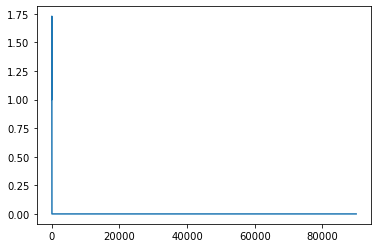

In [42]:
# Create environment
grid = test_standard_grid()

# Discount factor, epsilon-greedy probability
eps = 0.1
gamma = 0.9
epsilon = 1e-3

# Policies
Pi_eps_ini = {
    (2, 0): {'U': (1-eps)+eps/len(grid.adm_actions[(2, 0)]), 'R':eps/len(grid.adm_actions[(2, 0)])},
    (1, 0): {'U': (1-eps)+eps/len(grid.adm_actions[(1, 0)]), 'D':eps/len(grid.adm_actions[(1, 0)])},
    (0, 0): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 0)]), 'D':eps/len(grid.adm_actions[(0, 0)])},
    (0, 1): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 1)]), 'L':eps/len(grid.adm_actions[(1, 0)])},
    (0, 2): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 2)]), 'D':eps/len(grid.adm_actions[(0, 2)]),\
                                                             'L':eps/len(grid.adm_actions[(0, 2)])},
    (1, 2): {'U': (1-eps)+eps/len(grid.adm_actions[(1, 2)]), 'D':eps/len(grid.adm_actions[(1, 2)]),\
                                                             'R':eps/len(grid.adm_actions[(1, 2)])},
    (2, 1): {'R': (1-eps)+eps/len(grid.adm_actions[(2, 1)]), 'L':eps/len(grid.adm_actions[(2, 1)])},
    (2, 2): {'U': (1-eps)+eps/len(grid.adm_actions[(2, 2)]), 'L':eps/len(grid.adm_actions[(2, 2)]),\
                                                             'R':eps/len(grid.adm_actions[(2, 2)])},
    (2, 3): {'L': (1-eps)+eps/len(grid.adm_actions[(2, 3)]), 'U':eps/len(grid.adm_actions[(2, 3)])},
  }

Pi_unif = {}
for s in grid.non_term_states:
    Pi_unif[s]={}
    for a in grid.adm_actions[s]:
        Pi_unif[s][a] = 1/len(grid.adm_actions[s])

Pi_opt = {
    (2, 0): {'U': 1.0},
    (1, 0): {'U': 1.0},
    (0, 0): {'R': 1.0},
    (0, 1): {'R': 1.0},
    (0, 2): {'R': 1.0},
    (1, 2): {'U': 1.0},
    (2, 1): {'R': 1.0},
    (2, 2): {'U': 1.0},
    (2, 3): {'L': 1.0},
  }

Pi_lect = {
    (2, 0): {'U': 1.0},
    (1, 0): {'U': 1.0},
    (0, 0): {'R': 1.0},
    (0, 1): {'R': 1.0},
    (0, 2): {'R': 1.0},
    (1, 2): {'R': 1.0},
    (2, 1): {'R': 1.0},
    (2, 2): {'R': 1.0},
    (2, 3): {'U': 1.0},
  }



# Initialize other algorithm arguments:
T_max = 200
N_samples = 90000
alpha = 1
eps = 0.05

# Evaluate policy with TD(0) prediction
V, N_iter, deltas = TD_0_Prediction(Pi_unif, grid, gamma, alpha, N_samples, T_max, epsilon)

print(f"Finished running TD_0_Prediction with N_iter={N_iter} samples.")

# Print the value function
print_values(V, grid)

# Plot the deltas
plt.plot(deltas)

'''
Monte Carlo evaluations of policies above:

## Value function of Pi_eps_ini, eps = 0.1 ##
N_samples = 10000, T_max = 50
------------------------
 0.79| 0.88| 0.99| 0.00|
------------------------
 0.70| 0.00| 0.83| 0.00|
------------------------
 0.63| 0.65| 0.72| 0.63|
------------------------

## Value function of Pi_opt ##
N_samples = 10000, T_max = 50
------------------------
 0.81| 0.90| 1.00| 0.00|
------------------------
 0.73| 0.00| 0.90| 0.00|
------------------------
 0.66| 0.73| 0.81| 0.73|
------------------------

## Value function of Pi_unif ##
N_samples = 10000, T_max = 200
------------------------
 0.05| 0.13| 0.25| 0.00|
------------------------
-0.03| 0.00|-0.27| 0.00|
------------------------
-0.09|-0.19|-0.38|-0.77|
------------------------

'''



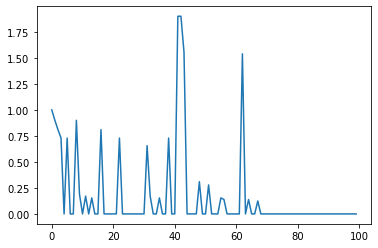

In [29]:
plt.plot(deltas[:100])

for the policy used above, MC policy evaluation yields:

In [32]:
V_MC = MC_Stochastic_Policy_Eval(Pi_unif, grid, gamma, 10000, 50, all_visits_MC= False)
print_values(V_MC, grid)

## VALUE FUNCTION ##
------------------------
 0.04| 0.13| 0.25| 0.00|
------------------------
-0.04| 0.00|-0.24| 0.00|
------------------------
-0.09|-0.18|-0.37|-0.76|
------------------------


This algorithm doesn't give accurate estimations. These depend on the step size $\alpha$, the starting state of the episodes, and differ significantly from one execution to the next.

## **3 - SARSA:**

SARSA stands for updates using tuples $(s,a,r,s',a')$. The basics are explained in Lecture 72:

* SARSA is an on-policy control TD learning algorithm. As seen in MC, we now estimate $Q_\pi$ instead of $V_\pi$.

* The SARSA update at step $t$ is:

$$Q(s_t, a_t) = Q(s_t, a_t)+\alpha\left\{r(s_t,a_t,s_{t+1})+\gamma Q(s_{t+1},a_{t+1})-Q(s_t, a_t)\right\}.$$

* It's worth noting that this control algorithm is still inspired by generalized policy iteration, and that the update above is just the $Q$ version of the TD(0) prediction update.

* Typically, we expect an $\varepsilon$-greedy policy as input for SARSA, as these are good candidates for the explore-exploit trade-off. An easy to remember explanation is that we want to assign the highest probability to the best action, given that this will maximize the returns, but at the same time we want to collect as many samples as possible by having actions of non-zero probabilies, and hence get more accurate estimates of state-action calues.

* Pseudocode:

            Init. Q(s,a) randomly for all (s,a).
            while not converged:
                s = env.reset()
                a = epsilon_greedy{Q(s,-)}
                while s not terminal:
                    Compute s' and r=r(s,a,s')
                    a' = epsilon_greedy{Q(s',-)}
                    Update: Q(s,a) = Q(s,a) +alpha*(r+gamma*Q(s',a')-Q(s,a))
                    Update: (s,a) = (s',a')

* Note that in principle, we shouldn't be evaluating Q from an input policy, as we're aiming to get a policy from Q.

* Lazy Programmer doesn't define a convergence criterion for the sample episode loop, he just gives a maximal number of samples. Another peculiarity is that even in Sutton and Barto, the pseudocode doesn't explicitly refer to storing the optimal policy.


In [58]:
def SARSA_Alg(Pi, env, gamma, alpha, N_samples, T_max, epsilon):
    '''
    Function implementing the Q-learning algorithm for TD control.
    (Pi should be an epsilon-greedy policy according to instructor)
    In principle, the input/behavior policy Pi is epsilon greedy,
    while the output/target policy Pi_star is greedy.
    I'm starting with a 
     ARGUMENTS: - Pi, env, gamma: Policy, environment, discount factor.
                - alpha: Step size parameter, float in ]0,1[.
                - N_samples: Max. no. of sample episodes.
                - T_max: Max. episode length minus 1.
                - epsilon: Floar, conv. threshold
                
     OUTPUT:    - V:=V_Pi, value function obtained.
    '''
    
    # Environment attributes
    adm_actions = env.adm_actions
    non_term_states = env.non_term_states
    term_states = env.term_states
    Rwds = env.rewards
    
    # Init. Q and Pi_star
    Q = {}
    Pi_star = {}
    for s in term_states:
        Q[s]= {"":0.0}
    for s in non_term_states:
        Q[s] = {}
        for a in adm_actions[s]:
            Q[s][a] = 0.0
            # I'm not sure about this last line...
    # Should output a policy where Pi_star[s] = {a_star(s):1.0}
        
    # Init. counters
    N_iter = 0
    T = 0
    deltas = []
    
        
    # Sample episode loop
    while (N_iter<N_samples):
        
        # Generate s_0 randomly
        s_old = list(non_term_states)[np.random.randint(len(non_term_states))]
        # Lazy Programmer always starts at (2,0)
        #s_old = (2, 0)
        if s_old in non_term_states:
            ind_rand = np.random.choice(len(Pi[s_old].values()), p=list(Pi[s_old].values()))
            a_old = list(Pi[s_old].keys())[ind_rand]
        else:
            a_old = ""
        
        # Init. delta_V
        delta_Q = 0
        
        # Episode steps loop
        # Note: Should I really impose this max episode length?
        while (s_old not in term_states) and (T<T_max):
            
            # WARNING: Modify for other environments
            # Compute new state
            if a_old == 'U':
                s_new = (s_old[0]-1, s_old[1])
            elif a_old == 'D':
                s_new = (s_old[0]+1, s_old[1])
            elif a_old == 'L':
                s_new = (s_old[0], s_old[1]-1)
            elif a_old == 'R':
                s_new = (s_old[0], s_old[1]+1)
            
            if s_new in non_term_states:
                # Get random index and 
                # probs = list(Pi[s_old].values())
                ind_rand = np.random.choice(len(Pi[s_new].values()), p=list(Pi[s_new].values()))
                # Sample action following Pi(-|s_old)
                a_new = list(Pi[s_new].keys())[ind_rand]
            else:
                a_new = ""
            
            # Get reward
            r_new = Rwds.get(s_new,0)
            
            # Update Q(s,a)
            Q[s_old][a_old] = Q[s_old][a_old]+ alpha*(r_new + gamma*Q[s_new][a_new]  - Q[s_old][a_old])
            
            # Update state for next step
            s_old = s_new
            a_old = a_new
            
            # Update T
            T += 1
            
        # Update deltas
        #deltas.append(delta_V)
               
        
        # Update N_iter
        N_iter += 1
        
        # END WHILE over episode steps     
    # END WHILE over samples    
    
    # Update Pi_star:
    for s in non_term_states:
        a_star = max(Q[s], key = Q[s].get)
        Pi_star[s] = {a_star:1.0}
    
    return Pi_star, N_iter, Q, deltas

# END DEF SARSA_Alg()

In [59]:
# Create environment
grid = test_standard_grid()

# Discount factor, epsilon-greedy probability
eps = 0.1
gamma = 0.9
epsilon = 1e-3

# Policies
Pi_eps_ini = {
    (2, 0): {'U': (1-eps)+eps/len(grid.adm_actions[(2, 0)]), 'R':eps/len(grid.adm_actions[(2, 0)])},
    (1, 0): {'U': (1-eps)+eps/len(grid.adm_actions[(1, 0)]), 'D':eps/len(grid.adm_actions[(1, 0)])},
    (0, 0): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 0)]), 'D':eps/len(grid.adm_actions[(0, 0)])},
    (0, 1): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 1)]), 'L':eps/len(grid.adm_actions[(1, 0)])},
    (0, 2): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 2)]), 'D':eps/len(grid.adm_actions[(0, 2)]),\
                                                             'L':eps/len(grid.adm_actions[(0, 2)])},
    (1, 2): {'U': (1-eps)+eps/len(grid.adm_actions[(1, 2)]), 'D':eps/len(grid.adm_actions[(1, 2)]),\
                                                             'R':eps/len(grid.adm_actions[(1, 2)])},
    (2, 1): {'R': (1-eps)+eps/len(grid.adm_actions[(2, 1)]), 'L':eps/len(grid.adm_actions[(2, 1)])},
    (2, 2): {'U': (1-eps)+eps/len(grid.adm_actions[(2, 2)]), 'L':eps/len(grid.adm_actions[(2, 2)]),\
                                                             'R':eps/len(grid.adm_actions[(2, 2)])},
    (2, 3): {'L': (1-eps)+eps/len(grid.adm_actions[(2, 3)]), 'U':eps/len(grid.adm_actions[(2, 3)])},
  }

Pi_unif = {}
for s in grid.non_term_states:
    Pi_unif[s]={}
    for a in grid.adm_actions[s]:
        Pi_unif[s][a] = 1/len(grid.adm_actions[s])

Pi_opt = {
    (2, 0): {'U': 1.0},
    (1, 0): {'U': 1.0},
    (0, 0): {'R': 1.0},
    (0, 1): {'R': 1.0},
    (0, 2): {'R': 1.0},
    (1, 2): {'U': 1.0},
    (2, 1): {'R': 1.0},
    (2, 2): {'U': 1.0},
    (2, 3): {'L': 1.0},
  }

# Initialize other algorithm arguments:
T_max = 200
N_samples = 90000
alpha = 1
eps = 0.05

# Execute SARSA algorithm
Pi_star, N_iter, Q, deltas = SARSA_Alg(Pi_eps_ini, grid, gamma, alpha, N_samples, T_max, epsilon)

print(f"Finished running Q-learning with N_iter={N_iter} samples.")
print_policy(Pi_star, grid)

Finished running Q-learning with N_iter=90000 samples.
##  POLICY  ##
------------------------
  R  |  R  |  R  |
------------------------
  U  |     |  U  |
------------------------
  U  |  R  |  U  |  L  |
------------------------


## **4 - Q-Learning:**

* Q-learning is one of the most popular reinforcement learning algorithms, and has many variations, most notably deep Q-learning. This algorithm was a breakthrough made by Chris Watkins in his 1989 PhD thesis, and the proof of its convergence is the subject of a 1992 paper by Watkins and Dayan.

* The Q-learning algorithm can be described as follows:

            Init. Q(s,a) randomly for all (s,a).
            while not converged:
                s = env.reset()
                a = epsilon_greedy{Q(s,-)}
                while s not terminal:
                    Compute s' and r=r(s,a,s')
                    a = epsilon_greedy{Q(s',-)}
                    Update: Q(s,a) = Q(s,a) +alpha*(r+gamma*max_a'{Q(s',a')}-Q(s,a))
                    Update: s = s'


* In contrast with SARSA, Q-learning is its off-policy counterpart. The main update is not done just by bootstrapping the Bellman update, one immediately updates with the best possible action. 

* In principle, we have the *behavior* policy used to generate the episode steps (typically an $\varepsilon$-greedy policy), but the *target* (i.e. output) policy should be the greedy one. 



In [46]:
def Q_Learn(Pi, env, gamma, alpha, N_samples, T_max, epsilon):
    '''
    Function implementing the Q-learning algorithm for TD control.
    (Pi should be an epsilon-greedy policy according to instructor)
    In principle, the input/behavior policy Pi is epsilon greedy,
    while the output/target policy Pi_star is greedy.
    I'm starting with a 
     ARGUMENTS: - Pi, env, gamma: Policy, environment, discount factor.
                - alpha: Step size parameter, float in ]0,1[.
                - N_samples: Max. no. of sample episodes.
                - T_max: Max. episode length minus 1.
                - epsilon: Floar, conv. threshold
                
     OUTPUT:    - V:=V_Pi, value function obtained.
    '''
    
    # Environment attributes
    adm_actions = env.adm_actions
    non_term_states = env.non_term_states
    term_states = env.term_states
    Rwds = env.rewards
    
    # Init. Q and Pi_star
    Q = {}
    Pi_star = {}
    for s in term_states:
        Q[s]= {"":0.0}
    for s in non_term_states:
        Q[s] = {}
        for a in adm_actions[s]:
            Q[s][a] = 0.0
            # I'm not sure about this last line...
    # Should output a policy where Pi_star[s] = {a_star(s):1.0}
        
    # Init. counters
    N_iter = 0
    T = 0
    deltas = []
    
        
    # Sample episode loop
    while (N_iter<N_samples):
        
        # Generate s_0 randomly
        s_old = list(non_term_states)[np.random.randint(len(non_term_states))]
        # Lazy Programmer always starts at (2,0)
        #s_old = (2, 0)
        
        # Init. delta_V
        delta_Q = 0
        
        # Episode steps loop
        # Note: Should I really impose this max episode length?
        while (s_old not in term_states) and (T<T_max):
            
            # Get random index and 
            # probs = list(Pi[s_old].values())
            ind_rand = np.random.choice(len(Pi[s_old].values()), p=list(Pi[s_old].values()))
            # Sample action following Pi(-|s_old)
            a = list(Pi[s_old].keys())[ind_rand]
            
            # WARNING: Modify for other environments
            # Compute new state
            if a == 'U':
                s_new = (s_old[0]-1, s_old[1])
            elif a == 'D':
                s_new = (s_old[0]+1, s_old[1])
            elif a == 'L':
                s_new = (s_old[0], s_old[1]-1)
            elif a == 'R':
                s_new = (s_old[0], s_old[1]+1)
            
            r_new = Rwds.get(s_new,0)
            
            ###########################
            ## MODIFY FOR Q FUNCTION ##
            ###########################
            # Update V[s]
            #V_old = V[s_old]
            #V[s_old] = V[s_old]+ alpha*(r_new+gamma*V[s_new] -V[s_old])
            # Update delta_V
            #delta_V = max(delta_V, np.abs(V_old-V[s_old]))
            
            # Update Q(s,a)
            a_star = max(Q[s_new], key = Q[s_new].get)
            Q[s_old][a] = Q[s_old][a]+ alpha*(r_new + gamma*Q[s_new][a_star]  - Q[s_old][a])
            
            # Update state for next step
            s_old = s_new
            
            # Update T
            T += 1
            
        # Update deltas
        #deltas.append(delta_V)
               
        
        # Update N_iter
        N_iter += 1
        
        # END WHILE over episode steps     
    # END WHILE over samples    
    
    # Update Pi_star:
    for s in non_term_states:
        a_star = max(Q[s], key = Q[s].get)
        Pi_star[s] = {a_star:1.0}
    
    return Pi_star, N_iter, Q, deltas

# END DEF Q_Learn()

In [52]:
# Create environment
grid = test_standard_grid()

# Discount factor, epsilon-greedy probability
eps = 0.1
gamma = 0.9
epsilon = 1e-3

# Policies
Pi_eps_ini = {
    (2, 0): {'U': (1-eps)+eps/len(grid.adm_actions[(2, 0)]), 'R':eps/len(grid.adm_actions[(2, 0)])},
    (1, 0): {'U': (1-eps)+eps/len(grid.adm_actions[(1, 0)]), 'D':eps/len(grid.adm_actions[(1, 0)])},
    (0, 0): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 0)]), 'D':eps/len(grid.adm_actions[(0, 0)])},
    (0, 1): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 1)]), 'L':eps/len(grid.adm_actions[(1, 0)])},
    (0, 2): {'R': (1-eps)+eps/len(grid.adm_actions[(0, 2)]), 'D':eps/len(grid.adm_actions[(0, 2)]),\
                                                             'L':eps/len(grid.adm_actions[(0, 2)])},
    (1, 2): {'U': (1-eps)+eps/len(grid.adm_actions[(1, 2)]), 'D':eps/len(grid.adm_actions[(1, 2)]),\
                                                             'R':eps/len(grid.adm_actions[(1, 2)])},
    (2, 1): {'R': (1-eps)+eps/len(grid.adm_actions[(2, 1)]), 'L':eps/len(grid.adm_actions[(2, 1)])},
    (2, 2): {'U': (1-eps)+eps/len(grid.adm_actions[(2, 2)]), 'L':eps/len(grid.adm_actions[(2, 2)]),\
                                                             'R':eps/len(grid.adm_actions[(2, 2)])},
    (2, 3): {'L': (1-eps)+eps/len(grid.adm_actions[(2, 3)]), 'U':eps/len(grid.adm_actions[(2, 3)])},
  }

Pi_unif = {}
for s in grid.non_term_states:
    Pi_unif[s]={}
    for a in grid.adm_actions[s]:
        Pi_unif[s][a] = 1/len(grid.adm_actions[s])

Pi_opt = {
    (2, 0): {'U': 1.0},
    (1, 0): {'U': 1.0},
    (0, 0): {'R': 1.0},
    (0, 1): {'R': 1.0},
    (0, 2): {'R': 1.0},
    (1, 2): {'U': 1.0},
    (2, 1): {'R': 1.0},
    (2, 2): {'U': 1.0},
    (2, 3): {'L': 1.0},
  }

# Initialize other algorithm arguments:
T_max = 200
N_samples = 90000
alpha = 1
eps = 0.05

# Execute Q-learning algorithm
Pi_star, N_iter, Q, deltas = Q_Learn(Pi_unif, grid, gamma, alpha, N_samples, T_max, epsilon)

print(f"Finished running Q-learning with N_iter={N_iter} samples.")
print_policy(Pi_star, grid)

Finished running Q-learning with N_iter=90000 samples.
##  POLICY  ##
------------------------
  R  |  R  |  R  |
------------------------
  U  |     |  U  |
------------------------
  U  |  R  |  U  |  L  |
------------------------


At least the resulting policy is indeed optimal. The execution also seems much faster than MC control and SARSA.